# Phase diagrams for fluids containing asphaltenes

In `yaeos` its possible to calculate phase diagrams for fluids containing asphaltenes.
The presence of asphaltenes in a fluid can favor the formation of three-phase regions.

In [1]:
import numpy as np
import yaeos
import matplotlib.pyplot as plt

## System definition
Here we define a relatively simple system, where the last component corresponds
to asphaltenes. And model it with the PengRobinson78 EoS.
All the values were taken from literature.

In [37]:

# Definition of the system's parameters
names = ['CO2', 'C1', 'C2', 'C3', 'C4–C5', 'C6', 'R', 'Asphaltene']
Pc = [73.75, 45.99, 48.72, 42.48, 33.80, 30.12, 28.53, 9.25]
Tc = [304.14, 190.56, 305.32, 369.83, 460.40, 507.40, 766.89, 1390.50]
w = [0.239, 0.011, 0.099, 0.153, 0.227, 0.296, 0.517, 1.790]

MM = np.array([44.01, 16.04, 30.07, 44.10, 72.15, 84.00, 181.58, 750.00])

z =np.array([4.48, 38.04, 5.51, 3.45, 15.94, 0.52, 32.02398, 0.04602])
z = z/sum(z)

# Generate the kij matrix with zero values as default
kij = np.zeros((len(z), len(z)), order="F")

# CO2 Kij
kij[0, :] = kij[:, 0] = 0.15
kij[0, -1] = kij[-1, 0] = 0.22

idx = [i for i in range(2,len(z)-2)]
for i in range(2, len(z)-2):
    kij[1, i] = kij[i, 1] = 0.0289 + 1.633*10**-4 * MM[i]

kij[1, -1] = kij[-1, 1] = 0.0289 + 1.633*10**-4 * MM[-1]
kij[1, -2] = kij[-2, 1] = 0.0289 + 1.633*10**-4 * MM[-2]
kij[-1, -2] = kij[-2, -1]= 0.07

# Define the system
mixing_rule = yaeos.QMR(kij=kij, lij=0*kij)
model = yaeos.PengRobinson78(Tc, Pc, w, mixrule=mixing_rule)

## Phase diagram calculation
We can calculate the full phase diagram of a mixture at constant composition
with the `.isopleth` method.

In [38]:
model.isopleth?

Signature:
model.isopleth(
    z,
    dew_start=(500, 0.01),
    bubble_start=(200, 10),
    max_points=1000,
    delta_dew_2ph=0.01,
    delta_bub_2ph=0.01,
    delta_dsp_3ph=0.01,
    stop_pressure=2500,
)
Docstring: <no docstring>
File:      ~/docs/programming/python/virtualenvs/thermo/lib/python3.13/site-packages/yaeos/core.py
Type:      method

## Now we calculate the phase diagram
We provide some good intial guesses for at which T,P pairs the bubble and
dew line should start and an pressure value to stop in case a line goes into
infinity pressure values.

The output provides us a dictionary with keys:
- `2ph`: Whole two-phase envelopes
- `DSP`: Detected Double Saturation Points. These points are the points where
lines intersect with each other and are origins for three-phase regions.
- `2ph_stable`: The stable sections of the two-phase lines, which are discarded
automatically when particular cases are found.
- `3ph`: The three phase calculated lines, if there where any DSP found, they
will be a tuple of pairs of lines for each DSP, and multiple single lines for
the cases where there is no DSP.

In [48]:
res = model.isopleth(z, dew_start=(500, 0.01), bubble_start=(300, 200), stop_pressure=1000)
res.keys()

2


dict_keys(['2ph', 'DSP', '3ph', '2ph_stable'])

## 

Text(0, 0.5, 'Pressure (bar)')

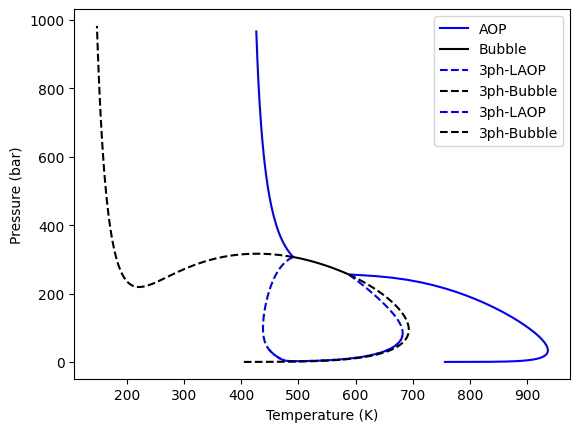

In [52]:
plt.plot(res["2ph_stable"]["dew"]["T"], res["2ph_stable"]["dew"]["P"], color="blue", label="AOP")
plt.plot(res["2ph_stable"]["bub"]["T"], res["2ph_stable"]["bub"]["P"], color="black", label="Bubble")

for i, dsp in enumerate(res["DSP"]):
    plt.plot(res["3ph"][i][0]["T"], res["3ph"][i][0]["P"], color="blue", label="3ph-LAOP", linestyle="--")
    plt.plot(res["3ph"][i][1]["T"], res["3ph"][i][1]["P"], color="black", label="3ph-Bubble", linestyle="--")

plt.legend()

plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")